<center><h1>Multi-class compound structural classification using sklearn</center></h1>

## About our dataset for today

The objective of this exercise is to predict the structural category of a compound using some properties derived from the monoisotopic mass and the molecular formula of the compound. ~40,000 plant lipids were classified in the following eight categories, out of which ~8000 lipids have been randomly chosen for this exercise.

<img src="Lipids.jpg" height="700" width="700">

We first used Weka for classification. Although Weka also has a command line interface and is quite easy to use, its functionality, especially for multiclass classification, is limited. SkLearn has a lot more functionality than Weka, is much more powerful in its libraries, options and execution, and is more actively developed.

The overall pipeline for analysis of the lipid dataset is as follows:

* We will first perform some exploratory analysis of the data to understand the distribution of the various features. This dataset has been filtered properly already, so there's not much to edit post exploratory analysis.

* We will divide the dataset into training and test data, and set up machine learning runs with 10X cross-validation. We will build a model with a Random Forest classifier using training data and use it to predict the class of the test dataset examples

* Then, we will estimate the accuracy of the classifier using various metrics.

* Finally, we will determine which features were important for classification purposes

If at any point you wish to determine the effect of changing some parameters on the output, or want to print some internal variables, feel free to edit the code cell and re-run the cell.

## Exploratory analysis of the data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

import seaborn as sns

#Read in the file
s = pd.read_csv('small_input_file.tab',sep="\t")
s.head()

#How many columns does it have? 

,#LMID,Name,Category,Subcategory,Formula,Mass,NumofC,NumofH,NumofO,NumofN,...,NumofS,H:C,H:O,C:O,C:N,C:S,C:P,Afterdecmass,AMD,RMD
0,LMFA01090153,"(2E,4Z)-3-chlorohexa-2,4-dienedioic_acid",Fatty_Acyls,Fatty_Acids_and_Conjugates,C6H5O4N0S0P0,141.018786,6,5,4,0,...,0,0.833333,1.250000,1.500000,0.0,0.0,0.0,0.9876,0.0124,70
1,LMFA01020226,"19-methyl-5Z,9Z-eicosadienoic_acid",Fatty_Acyls,Fatty_Acids_and_Conjugates,C21H38O2N0S0P0,322.287181,21,38,2,0,...,0,1.809524,19.000000,10.500000,0.0,0.0,0.0,0.2872,0.2872,891
2,LMFA01050382,2R-methyl-3-hydroxy-propanoic_acid,Fatty_Acyls,Fatty_Acids_and_Conjugates,C4H8O3N0S0P0,104.047345,4,8,3,0,...,0,2.000000,2.666667,1.333333,0.0,0.0,0.0,0.0473,0.0473,455
3,LMFA01050018,5-hydroxy-heptanoic_acid,Fatty_Acyls,Fatty_Acids_and_Conjugates,C7H14O3N0S0P0,146.094295,7,14,3,0,...,0,2.000000,4.666667,2.333333,0.0,0.0,0.0,0.0943,0.0943,645
4,LMFA01160015,"(2R)-2-[(1R)-1-hydroxy-19-{(1R,2R)-2-[(2R,19S,...",Fatty_Acyls,Fatty_Acids_and_Conjugates,C88H174O4N0S0P0,1295.341213,88,174,4,0,...,0,1.977273,43.500000,22.000000,0.0,0.0,0.0,0.3412,0.3412,263


In [2]:
#Get some basic numerical descriptors of the various columns
#Uncomment each of these lines one at a time
s.info()
#s.describe()

#REMEMBER: Categorical features CANNOT be used for machine learning unless you transform them somehow 
# into numerical features. 

#Questions:
#1) What are categorical features?
#2) Which features in this dataset can be used for machine learning?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   #LMID         8040 non-null   object 
 1   Name          6952 non-null   object 
 2   Category      8040 non-null   object 
 3   Subcategory   8040 non-null   object 
 4   Formula       8040 non-null   object 
 5   Mass          8040 non-null   float64
 6   NumofC        8040 non-null   int64  
 7   NumofH        8040 non-null   int64  
 8   NumofO        8040 non-null   int64  
 9   NumofN        8040 non-null   int64  
 10  NumofP        8040 non-null   int64  
 11  NumofS        8040 non-null   int64  
 12  H:C           8040 non-null   float64
 13  H:O           8040 non-null   float64
 14  C:O           8040 non-null   float64
 15  C:N           8040 non-null   float64
 16  C:S           8040 non-null   float64
 17  C:P           8040 non-null   float64
 18  Afterdecmass  8040 non-null 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88229901d0>,
      dtype=object)

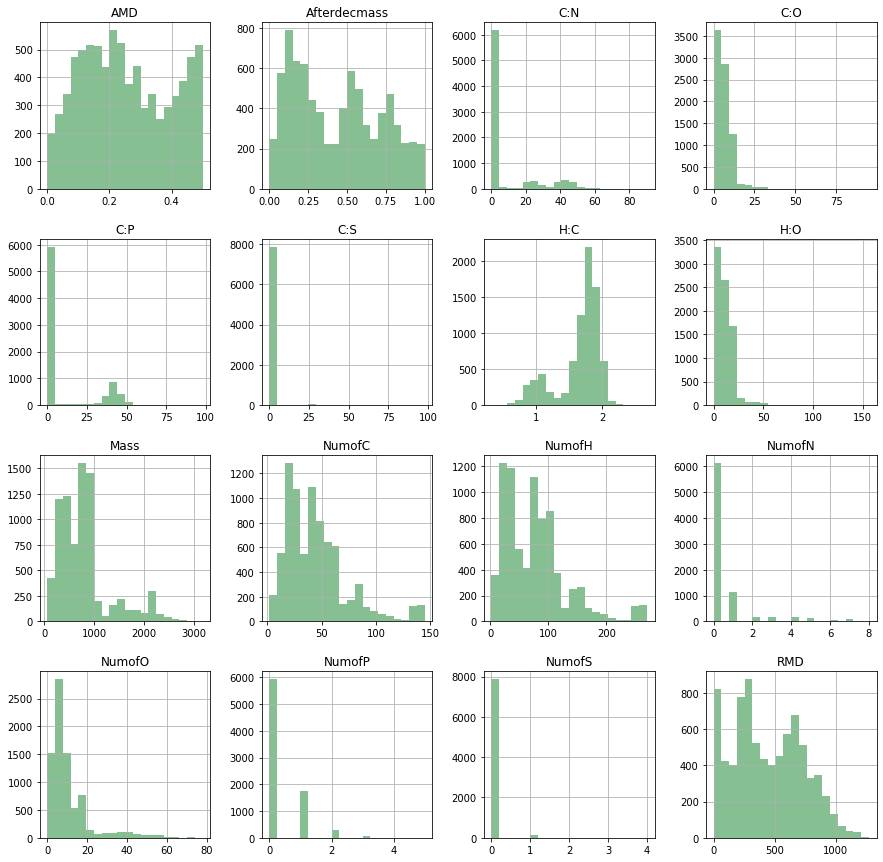

In [5]:
#Plotting the distributions of the various features
s.hist(bins=20,figsize=(15,15), color='#86bf91')

#What is matplotlib plotting here? Do you need to specify the variables to plot? Why?

__Exercise 1:__ 

In the above output, you will notice there was a big block of text printed before the plot. 
You can get rid of the text by putting a ; after the command. Try it. Make a new codeblock below this markdown block, and repeat the above command with a ; after it.

In [6]:
#Next we look at correlations between the different variables. 
allcorrel=s.corr()
allcorrel.columns
#len(allcorrel.columns)
allcorrel

#Why do you need to do this analysis? What will happen if correlated variables are included for training 
#the machine learning models?

,Mass,NumofC,NumofH,NumofO,NumofN,NumofP,NumofS,H:C,H:O,C:O,C:N,C:S,C:P,Afterdecmass,AMD,RMD
Mass,1.000000,0.961906,0.941778,0.819958,0.536618,0.149777,-0.019340,0.287180,-0.059477,-0.105774,0.263280,0.017273,0.108919,0.392486,-0.190673,-0.682131
NumofC,0.961906,1.000000,0.988105,0.638859,0.354107,0.092675,-0.080976,0.337453,0.096838,0.050010,0.181401,-0.043429,0.077555,0.523915,-0.177166,-0.653206
NumofH,0.941778,0.988105,1.000000,0.592213,0.348003,0.137449,-0.083642,0.462542,0.141324,0.075763,0.217010,-0.042224,0.130964,0.560491,-0.122242,-0.580713
NumofO,0.819958,0.638859,0.592213,1.000000,0.708235,0.095030,0.037181,0.027131,-0.376191,-0.398118,0.306878,0.053665,0.054290,0.000430,-0.228993,-0.596910
NumofN,0.536618,0.354107,0.348003,0.708235,1.000000,0.256545,0.306762,0.166060,-0.233511,-0.260604,0.474072,0.384644,0.022794,-0.048333,-0.035039,-0.281621
NumofP,0.149777,0.092675,0.137449,0.095030,0.256545,1.000000,0.235382,0.295533,-0.158070,-0.204811,0.296271,0.318955,0.808305,0.044792,0.317309,-0.040109
NumofS,-0.019340,-0.080976,-0.083642,0.037181,0.306762,0.235382,1.000000,-0.074099,-0.107746,-0.106768,-0.025029,0.768493,-0.039327,-0.052361,-0.049145,-0.081300
H:C,0.287180,0.337453,0.462542,0.027131,0.166060,0.295533,-0.074099,1.000000,0.365933,0.229781,0.292182,-0.015364,0.339068,0.472367,0.386169,0.251063
H:O,-0.059477,0.096838,0.141324,-0.376191,-0.233511,-0.158070,-0.107746,0.365933,1.000000,0.983299,-0.120117,-0.095386,-0.133213,0.350648,0.190391,0.254955
C:O,-0.105774,0.050010,0.075763,-0.398118,-0.260604,-0.204811,-0.106768,0.229781,0.983299,1.000000,-0.167863,-0.097351,-0.186255,0.291215,0.151964,0.239552


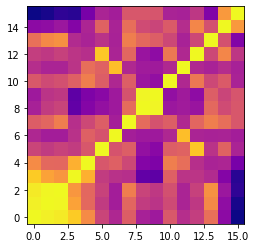

In [7]:
#Let us first plot a basic heatmap

fig, ax = plt.subplots()
ax.imshow(allcorrel,cmap='plasma',origin='lower')
plt.show()

As you can see, this does not efficiently make X-axis and Y-axis labels. We need to provide them separately.

In [ ]:
#Create empty plot variables
fig, ax = plt.subplots()

#Lets first set the ax
ax.imshow(allcorrel,cmap='plasma',origin='lower') #other color options: viridis, inferno, hot, magma, cividis etc
#https://matplotlib.org/tutorials/colors/colormaps.html

ax.set_xticks(np.arange(len(allcorrel.columns)))
ax.set_yticks(np.arange(len(allcorrel.columns)))
ax.set_xticklabels(allcorrel.columns) #X-axis labels
ax.set_yticklabels(allcorrel.columns) #Y-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor",size=12)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",size=12)
ax.set_title("Pairwise Pearsons Correlation Coefficients between features")

#Now set the fig
fig.set_size_inches(10,10)
fig.tight_layout()

Seaborn solves this problem of code complexity by making the whole block above basically a 3-line code block.

In [ ]:
#Seaborn code
plt.figure(figsize=(12,12))
ax = sns.heatmap(allcorrel, cmap="plasma")
ax.invert_yaxis()

__POP QUIZ:__ What does the above figure show?

## Setting up and executing the machine learning models

In [24]:
#import required modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
#Example Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [28]:
#First, define which columns are labels and which are features
labels=s['Category']
feats=s[s.columns[5:]] #Are these the correct columns? Go back to the table where you defined s and check.

#Additionally, uncomment each line below to print only the top 5 rows of each variable to make sure correct columns 
#were indeed pulled out
#print (feats.head())
#print (labels.head())

0    Fatty_Acyls
1    Fatty_Acyls
2    Fatty_Acyls
3    Fatty_Acyls
4    Fatty_Acyls
Name: Category, dtype: object


Split your data into training and test sets - here we are specifying the size of the test set as 0.2 (20%) of the main dataset, which has 8040 entries. We have to specify training and test labels as well as features. Check if the split is really 80:20.

In [64]:
train_feats, test_feats, train_labels, test_labels  = train_test_split (feats, labels, test_size=0.2)
test_labels

1270             Fatty_Acyls
6800           Sphingolipids
5859             Polyketides
2322           Glycerolipids
3195    Glycerophospholipids
                ...         
1836           Glycerolipids
1127             Fatty_Acyls
3594    Glycerophospholipids
7437           Sphingolipids
117              Fatty_Acyls
Name: Category, Length: 1608, dtype: object

In [30]:
#Lets make a function here to train our machine learning model
#We are running a multi-class classifier here, instead of a binary classifier (yes, no)
def random_forest_classifier(features, target):
    """
    To train the random forest classifier with features and target data
    :param features: features
    :param target: labels
    :return: trained random forest classifier
    """
    clf = RandomForestClassifier(n_estimators=100)
    #estimators stands for the number of decision trees you want to implement
    #Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    clf.fit(features, target)
    y_score=clf.predict_proba(targ)[:, 1]
    return clf

In [61]:
#Running the randomForestClassifier
trained_model = random_forest_classifier(train_feats, train_labels)

#Let's see if the trained model predicts the test features correctly. 
pred_labels=trained_model.predict(test_feats)
pred_probs=trained_model.predict_proba(test_feats)
#trained_model #This just shows you the model, and in this case we are only using default values, so its showing up as ().
#pred_labels
pred_probs #Probabilities of each test instance belonging to each class

array([[1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 1.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.6125, 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]])

In [80]:
len(pred_probs)

1608

In [86]:
#Now check how many elements are contained within pred_labels. Is it a matrix of values?
dfx = pd.concat([test_feats, pd.DataFrame(pred_labels, columns=["Predicted labels"]), 
                 pd.DataFrame(pred_probs, columns=["A","B","C","D","E","F","G","H"])], axis=1)
dfx.to_csv(path_or_buf="results.tab",index=True,sep='\t')

#Check the output. Is it correct?

,index,Mass,NumofC,NumofH,NumofO,NumofN,NumofP,NumofS,H:C,H:O,...,RMD,Predicted labels,A,B,C,D,E,F,G,H
0,1270,116.120115,7,16,1,0,0,0,2.285714,16.000000,...,1034,Fatty_Acyls,1.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.00
1,6800,975.589558,46,90,18,1,1,0,1.956522,5.000000,...,421,Glycerolipids,0.000000,1.0,0.0,0.0000,0.000000,0.0,0.0,0.00
2,5859,624.169041,28,32,16,0,0,0,1.142857,2.000000,...,271,Fatty_Acyls,0.612500,0.0,0.0,0.3875,0.000000,0.0,0.0,0.00
3,2322,840.720692,54,96,6,0,0,0,1.777778,16.000000,...,332,Glycerolipids,0.000000,1.0,0.0,0.0000,0.000000,0.0,0.0,0.00
4,3195,1656.789958,74,129,38,0,1,0,1.743243,3.394737,...,127,Sphingolipids,0.000000,0.0,0.0,0.0000,0.000000,0.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,1836,912.720692,60,96,6,0,0,0,1.600000,16.000000,...,306,Fatty_Acyls,0.710000,0.0,0.0,0.0700,0.040000,0.0,0.0,0.18
1604,1127,334.214411,20,30,4,0,0,0,1.500000,7.500000,...,642,Prenol_Lipids,0.427635,0.0,0.0,0.0000,0.572365,0.0,0.0,0.00
1605,3594,829.656058,47,92,8,1,1,0,1.957447,11.500000,...,415,Glycerophospholipids,0.000000,0.0,1.0,0.0000,0.000000,0.0,0.0,0.00
1606,7437,1707.929489,79,141,36,3,0,0,1.784810,3.916667,...,41,Sphingolipids,0.000000,0.0,0.0,0.0000,0.000000,0.0,1.0,0.00


In [110]:
test_labels

1270             Fatty_Acyls
6800           Sphingolipids
5859             Polyketides
2322           Glycerolipids
3195    Glycerophospholipids
                ...         
1836           Glycerolipids
1127             Fatty_Acyls
3594    Glycerophospholipids
7437           Sphingolipids
117              Fatty_Acyls
Name: Category, Length: 1608, dtype: object

,Mass,NumofC,NumofH,NumofO,NumofN,NumofP,NumofS,H:C,H:O,C:O,C:N,C:S,C:P,Afterdecmass,AMD,RMD,Test_labels,Category
1270,116.120115,7,16,1,0,0,0,2.285714,16.000000,7.000000,0.000000,0.0,0.0,0.1201,0.1201,1034,Fatty_Acyls,Fatty_Acyls
6800,975.589558,46,90,18,1,1,0,1.956522,5.000000,2.555556,46.000000,0.0,46.0,0.5896,0.4104,421,Sphingolipids,Sphingolipids
5859,624.169041,28,32,16,0,0,0,1.142857,2.000000,1.750000,0.000000,0.0,0.0,0.1690,0.1690,271,Polyketides,Polyketides
2322,840.720692,54,96,6,0,0,0,1.777778,16.000000,9.000000,0.000000,0.0,0.0,0.7207,0.2793,332,Glycerolipids,Glycerolipids
3195,1656.789958,74,129,38,0,1,0,1.743243,3.394737,1.947368,0.000000,0.0,74.0,0.7900,0.2100,127,Glycerophospholipids,Glycerophospholipids
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,912.720692,60,96,6,0,0,0,1.600000,16.000000,10.000000,0.000000,0.0,0.0,0.7207,0.2793,306,Glycerolipids,Glycerolipids
1127,334.214411,20,30,4,0,0,0,1.500000,7.500000,5.000000,0.000000,0.0,0.0,0.2144,0.2144,642,Fatty_Acyls,Fatty_Acyls
3594,829.656058,47,92,8,1,1,0,1.957447,11.500000,5.875000,47.000000,0.0,47.0,0.6561,0.3439,415,Glycerophospholipids,Glycerophospholipids
7437,1707.929489,79,141,36,3,0,0,1.784810,3.916667,2.194444,26.333333,0.0,0.0,0.9295,0.0705,41,Sphingolipids,Sphingolipids


In [121]:
#Now check how many elements are contained within pred_labels. Is it a matrix of values?


dfx1 = pd.concat([test_feats, pd.DataFrame(test_labels)], axis=1, sort=False)
dfx = pd.concat([dfx1.reset_index(),
                 pd.DataFrame(pred_labels, columns=["Predicted labels"]), 
                 pd.DataFrame(pred_probs, columns=["A","B","C","D","E","F","G","H"])], axis=1)

dfx.to_csv(path_or_buf="results2.tab",index=True,sep='\t')

## Checking the overall performance of the model

In [40]:
#class_names=test_labels[unique_labels[test_labels, pred_labels]]
class_names=list(set(train_labels))
class_names

#This is the complete, unique list of labels in the training dataset

['Polyketides',
 'Fatty_Acyls',
 'Sphingolipids',
 'Prenol_Lipids',
 'Glycerolipids',
 'Glycerophospholipids',
 'Sterol_Lipids',
 'Saccharolipids']

In [57]:

len(pred_labels)

array(['Fatty_Acyls', 'Glycerophospholipids', 'Glycerolipids', ...,
       'Glycerophospholipids', 'Glycerophospholipids', 'Polyketides'],
      dtype=object)

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Using this model, predict labels of test features and see how well it behaves
for i in range(0, 20): #Change this number from 10 to something else (<20) and see what happens
        print ("Actual outcome :: {} and Predicted outcome :: {}".format(list(test_labels)[i], pred_labels[i]))
print("Overall accuracy:",accuracy_score(test_labels, pred_labels))

#What do you think was printed here? 
#Uncheck the following command. Run the block again and check the output as well as the above command.
#Can you tell now?

print (">>>", len(list(test_labels)))

#Confusion matrix
class_names=list(set(train_labels))
cm=confusion_matrix(test_labels, pred_labels, labels=class_names)
print (cm)

Actual outcome :: Fatty_Acyls and Predicted outcome :: Fatty_Acyls
Actual outcome :: Glycerolipids and Predicted outcome :: Glycerophospholipids
Actual outcome :: Polyketides and Predicted outcome :: Glycerolipids
Actual outcome :: Glycerolipids and Predicted outcome :: Polyketides
Actual outcome :: Sphingolipids and Predicted outcome :: Polyketides
Actual outcome :: Sterol_Lipids and Predicted outcome :: Sphingolipids
Actual outcome :: Saccharolipids and Predicted outcome :: Glycerolipids
Actual outcome :: Glycerophospholipids and Predicted outcome :: Polyketides
Actual outcome :: Fatty_Acyls and Predicted outcome :: Polyketides
Actual outcome :: Fatty_Acyls and Predicted outcome :: Glycerolipids
Actual outcome :: Polyketides and Predicted outcome :: Sterol_Lipids
Actual outcome :: Saccharolipids and Predicted outcome :: Sphingolipids
Actual outcome :: Polyketides and Predicted outcome :: Sphingolipids
Actual outcome :: Sterol_Lipids and Predicted outcome :: Glycerolipids
Actual outco

In [17]:
#Normalized confusion matrix
#Here we are normalizing each of the value above by the total number of examples of each category in the test dataset
cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]*100
cm

array([[ 98.94736842,   0.70175439,   0.        ,   0.        ,
          0.        ,   0.        ,   0.35087719,   0.        ],
       [  0.6779661 ,  95.25423729,   0.        ,   2.71186441,
          0.        ,   0.        ,   1.3559322 ,   0.        ],
       [  0.        ,   2.48447205,  96.89440994,   0.        ,
          0.        ,   0.62111801,   0.        ,   0.        ],
       [  3.92156863,  19.60784314,   0.        ,  64.70588235,
          1.96078431,   1.96078431,   7.84313725,   0.        ],
       [  0.        ,   0.76335878,   0.        ,   0.38167939,
         98.85496183,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 100.        ,   0.        ,   0.        ],
       [  1.81818182,   9.09090909,   0.        ,   3.63636364,
          0.90909091,   0.        ,  84.54545455,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.4925373

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

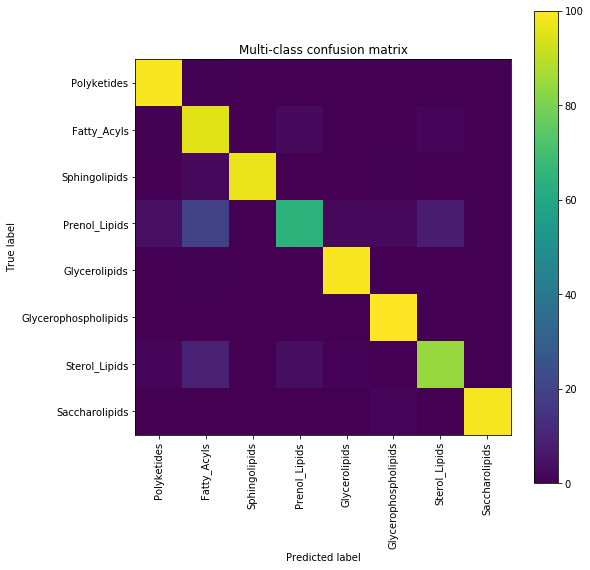

In [18]:
#Plotting the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap="viridis")
ax.figure.colorbar(im, ax=ax)
fig.set_size_inches(7,7)
fig.tight_layout()

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=class_names, yticklabels=class_names,
       title="Multi-class confusion matrix",
       ylabel='True label',
       xlabel='Predicted label')
#ax.tick_params(direction=2)
plt.xticks(rotation=90)

### Exercise 1:

* What does the plot show?
* Which structural categories was the model able to classify properly, and where was it confused?
* Why do you think the model was confused by those categories? What is it confused with? Why? Refer to the category definitions shown above to address these questions.


## Plotting the Area Under the Receiver Operating Characteristic (AUROC) curve

AUROC curve is always in a binary context, while here we have run a multiclass classifier. 
Hence, it is important to format the AUROC calculations in a way that enables binary calculation/plotting. We will convert all labels into only two types -- Fatty Acyls and Not Fatty Acyls - and run the classifier again

In [19]:
#Plotting the Area Under the Receiver Operating Characteristic (AUROC) curve
from sklearn.metrics import roc_curve, auc

#Get the labels and features again, just so that we don't mess up the original variables
labels2=s['Category']
feats2=s[s.columns[5:]]
train_feats2, test_feats2, train_labels2, test_labels2  = train_test_split (feats2, labels2, test_size=0.2)

for name in class_names:
    #print (name)
    if name=='Fatty_Acyls':
        pass
    else:
        train_labels2=pd.Series(train_labels2).str.replace(name,'Not_Fatty_Acyls') #replace labels in training
        test_labels2=pd.Series(test_labels2).str.replace(name,'Not_Fatty_Acyls') #replace labels in test

#Run Random Forest classifier on them and print the overall model score
rf = RandomForestClassifier(n_estimators=100, oob_score=True) 
trained_model2 = rf.fit(train_feats2, train_labels2)
model_scores2=rf.score(test_feats2, test_labels2)
print ("Overall model score: ", model_scores2)

Overall model score:  0.9776119402985075


In [20]:
#Get the Area Under the Receiver Operating Characteristic (AUC-ROC or AUROC)
y_score=trained_model2.predict_proba(test_feats2)[:, 1]
fpr, tpr, _ = roc_curve(test_labels2, y_score, pos_label='Not_Fatty_Acyls')
#For some reason, the data structure has been encoded such that the pos_label is reversed. This is something
#I need to figure out why. Change pos_label to Fatty_Acyls and see how the AUROC figure changes below.
#Does the figure make sense? Can AUROC be lower than random expectation?

roc_auc = auc(fpr, tpr)
#print (fpr, tpr, roc_auc)

In [60]:
type(y_score)

numpy.ndarray

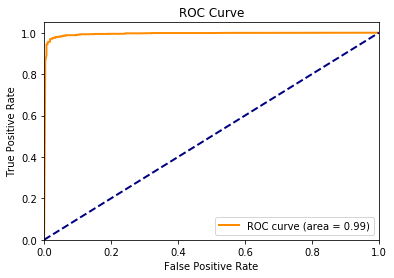

In [21]:
#Plot the AUROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Finding which features were important for binary classification of Fatty Acyls

Feature importance is calculated as a specific metric, which is different for different algorithms. See a detailed review here: https://machinelearningmastery.com/calculate-feature-importance-with-python/. In our case, rf.feature_importance_ method by default uses the Gini impurity decrease method, which calculates the drop in "impurity" of the predicted labels, if individual features were removed from the nodes of the RF decision trees.

There are some issues with this metric with certain types of datasets. Depending on your data structure, you may need to choose different feature importance measures.

              importance
Mass            0.196908
NumofO          0.157511
NumofC          0.122299
H:C             0.118248
RMD             0.096803
NumofH          0.051200
C:O             0.046615
Afterdecmass    0.044010
H:O             0.035712
AMD             0.030058
NumofP          0.027019
NumofN          0.025913
C:N             0.017857
C:S             0.012084
NumofS          0.010543
C:P             0.007220


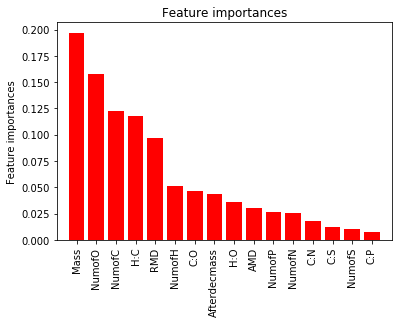

In [22]:
## Feature importance


feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = train_feats2.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Print the feature ranking
print (feature_importances)

# Plot the feature importances of the forest
figcolumns=feature_importances.index.values
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_feats2.shape[1]), feature_importances.importance,
       color="r", align="center")
plt.ylabel("Feature importances")
plt.xticks(range(train_feats2.shape[1]), figcolumns, rotation='vertical')
plt.xlim([-1, train_feats2.shape[1]])
plt.show()

__Copy-paste the above plot into a Word File or a Powerpoint presentation__

__Exercise 2__:

* Do the feature importances make sense, based on what you know about Fatty Acyls?
* Repeat the binary classification with Glycerophospholipids and Sphingolipids, and check which features are important.

## Writing the predictions to output

This is the final step in our analysis.

In [44]:
pred_labels

array(['Fatty_Acyls', 'Glycerophospholipids', 'Glycerolipids', ...,
       'Glycerophospholipids', 'Glycerophospholipids', 'Polyketides'],
      dtype=object)

This concludes our exercise for today.

As you can see, the coding required for Python SciKit for running ML is fairly complicated, compared to the graphical interface of Weka. However, SciKit is very powerful, and once you get past the learning curve, you will be able to quickly run different algorithms using the HPC environment. SciKit also allows encoding neural networks as well as multi-label classification (not multi-class) -- where individual instances can be assigned to more than one labels -- which is not possible in Weka. 

In the next lecture, we will see how the problem of complexity of sklearn is addressed by a different package that was just released in April 2020.

Look out for large datasets and relevant classification questions where ML can be applied! Let us know too, so that we can use those datasets in future classes!

Happy coding!